# Treinamento de Rede Neural com Tensorflow para análise do sinal

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from libs.commpy_mod import SISOFlatChannel

from files_01_detection.const_mod import generate_symbols, Model
from files_01_detection.const_analyzer import plot_decision_boundary, theoretical_ser, ser, plot_confusion_matrix, plot_symbols
 
%matplotlib inline

2022-12-07 10:50:35.781996: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-07 10:50:35.782020: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-07 10:50:35.812053: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-07 10:50:36.517912: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-07 10:50:36.517991: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

## Definição e transmissão do sinal pelo canal

In [3]:
Mod = 'QAM'
channel_type = 'rayleigh' # 'awgn' or 'crazy'
M            = 16      # PSK modulation
total_num_symbols  = 1000000    # Number of transmitted symbols to be used for training and test
train_fraction = 0.5 # Fraction of whole data to be used for training (the remaining is for testing)
SNR_dB       = 15      # Signal to noise ratio in dB     
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy

In [4]:
#plot theoretical symbol error probability (SER) for this SNR
Pe = theoretical_ser(Mod, M, SNR_dB, channel_type, Es)
print("Theoretical symbol error probability (SER) =", Pe, " for SNR =", SNR_dB,"dB")

NameError: name 'theoretical_ser' is not defined

In [ ]:
symbs, indices, channel_output = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB)

In [5]:
# Generate dataset
# Train
train_size = int(train_fraction*total_num_symbols) #data used for training
y_train = np.append(np.array([[]]), indices[:train_size])
X_train = np.stack([np.real(channel_output[:train_size]),
                    np.imag(channel_output[:train_size])], axis=1)

# Test
y_test = np.append(np.array([[]]), indices[train_size:])
X_test = np.stack([np.real(channel_output[train_size:]),
                   np.imag(channel_output[train_size:])], axis=1)

scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

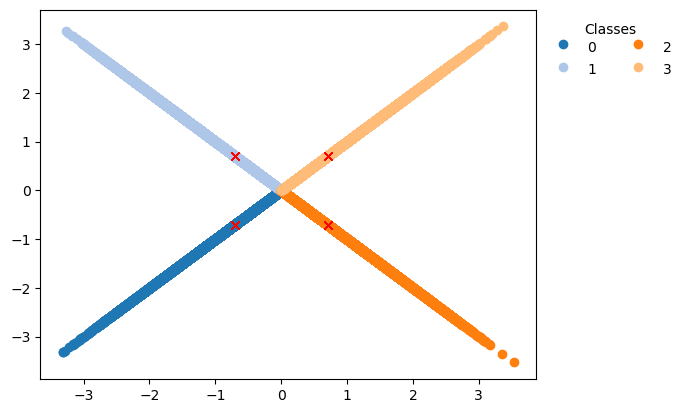

In [6]:
plot_symbols(X_train, y_train, M, symbs)

## Criação e treinamento da Rede Neural

In [7]:
n_inputs = np.shape(X_train)[1]
n_hidden1 = 20
n_hidden2 = 10
n_outputs = M
learning_rate = 0.001
n_epochs = 100
batch_size = 5000

y_train = tf.reshape(tf.convert_to_tensor(y_train), [-1, 1])
y_test = tf.reshape(tf.convert_to_tensor(y_test), [-1, 1])
X_test = tf.convert_to_tensor(X_test)
X_train = tf.convert_to_tensor(X_train)

2022-12-07 10:02:09.251915: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-07 10:02:09.252015: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-07 10:02:09.252092: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-07 10:02:09.252165: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-12-07 10:02:09.252237: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

### Usando API Keras

In [8]:
inputs = tf.keras.Input(shape=(2,))

x = tf.keras.layers.Dense(n_hidden1, activation="relu", kernel_initializer="glorot_normal")(inputs)
x = tf.keras.layers.Dense(n_hidden2, activation="relu", kernel_initializer="glorot_normal")(x)
output = tf.keras.layers.Dense(n_outputs, kernel_initializer="glorot_normal")(x)

modelK = tf.keras.Model(inputs=inputs, outputs=output)

modelK.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
Total params: 358
Trainable params: 358
Non-trainable params: 0
_________________________________________________________________


In [9]:
modelK.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
             metrics=["accuracy"])

history = modelK.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, shuffle=True)

tests_score = modelK.evaluate(X_test, y_test)
print("Test loss:", tests_score[0])
print("Test accuracy:", tests_score[1])
print(f"Taxa de erro simbólica de {(1 - tests_score[1]):.2%}")

Epoch 1/100
100/100 [==============================] - 1s 3ms/step - loss: 2.0586 - accuracy: 0.1743
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 2.0492 - accuracy: 0.2110
Epoch 3/100
100/100 [==============================] - 0s 3ms/step - loss: 2.0389 - accuracy: 0.2424
Epoch 4/100
100/100 [==============================] - 0s 3ms/step - loss: 2.0285 - accuracy: 0.2942
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 2.0189 - accuracy: 0.3292
Epoch 6/100
100/100 [==============================] - 0s 3ms/step - loss: 2.0100 - accuracy: 0.3440
Epoch 7/100
100/100 [==============================] - 0s 3ms/step - loss: 2.0014 - accuracy: 0.3503
Epoch 8/100
100/100 [==============================] - 0s 3ms/step - loss: 1.9930 - accuracy: 0.3531
Epoch 9/100
100/100 [==============================] - 0s 3ms/step - loss: 1.9848 - accuracy: 0.3537
Epoch 10/100
100/100 [==============================] - 0s 3ms/step - loss: 1.9766 - accura

### Modelo de Rede Neural Criado

In [10]:
y_test = tf.cast(tf.reshape(y_test, -1),tf.int32)
y_train = tf.cast(tf.reshape(y_train, -1),tf.int32)

In [11]:
class DenseLayer(tf.Module):
    def __init__(self, n_neurons, name=None):
        super().__init__(name=name)
        self.n_neurons = n_neurons
        self.is_built = False
        
    def __call__(self, X, activation=None, name=None):
        if not self.is_built:
            self.w = tf.Variable(tf.random.truncated_normal((X.shape[-1], self.n_neurons), stddev=(2 / tf.sqrt(tf.cast(self.n_neurons + X.shape[-1], tf.float32)))), name=str(name)+"W")
            self.b = tf.Variable(tf.zeros([self.n_neurons]), dtype=tf.float32, name=str(name)+"b")
            self.is_built = True
            
        Z = tf.matmul(X, self.w) + self.b
        if activation is None:
            return Z
        else:
            return activation(Z)

In [12]:
class SequencialModel(tf.Module):
    def __init__(self, n_hidden=None, name=None):
        super().__init__(name=name)
        
        self.hidden1 = DenseLayer(n_hidden1)
        self.hidden2 = DenseLayer(n_hidden2)
        self.output = DenseLayer(n_outputs)
    
    def __call__(self, X):
        x = self.hidden1(tf.cast(X, tf.float32), activation=tf.nn.relu, name="hidden1-")
        x = self.hidden2(x, activation=tf.nn.relu, name="hidden2-")
        
        return self.output(x, name="output-")

In [13]:
model = SequencialModel()

In [14]:
def loss(y, logits):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))

In [15]:
def train(model, x, y, learning_rate):
    with tf.GradientTape() as g:
        current_loss = loss(y, tf.cast(model(x), tf.float32))
        
    dp = g.gradient(current_loss, model.trainable_variables)
    
    for i in range(len(model.trainable_variables)):
        model.trainable_variables[i].assign_sub(learning_rate * dp[i])

In [16]:
def minilote(model, x, y):
    for _ in range(n_epochs):
        for interation in range(x.shape[0] // batch_size):
            X_batch, y_batch = x[interation*batch_size:(interation+1)*batch_size], y[interation*batch_size:(interation+1)*batch_size]
            train(model, X_batch, y_batch, learning_rate)
        print(f"Época número {_}, precisão de {accuracy(model, x, y):.2%}")

In [17]:
def accuracy(model, x, y):
    correct = tf.nn.in_top_k(y, model(x), 1)
    return tf.reduce_mean(tf.cast(correct, tf.float32))

In [18]:
minilote(model, X_train, y_train)

Época número 0, precisão de 21.37%
Época número 1, precisão de 23.50%
Época número 2, precisão de 24.05%
Época número 3, precisão de 25.24%
Época número 4, precisão de 26.34%
Época número 5, precisão de 27.72%
Época número 6, precisão de 29.57%
Época número 7, precisão de 31.02%
Época número 8, precisão de 31.49%
Época número 9, precisão de 32.03%
Época número 10, precisão de 32.63%
Época número 11, precisão de 33.29%
Época número 12, precisão de 33.96%
Época número 13, precisão de 34.60%
Época número 14, precisão de 35.28%
Época número 15, precisão de 35.93%
Época número 16, precisão de 36.53%
Época número 17, precisão de 37.07%
Época número 18, precisão de 37.54%
Época número 19, precisão de 38.05%
Época número 20, precisão de 38.66%
Época número 21, precisão de 39.33%
Época número 22, precisão de 40.02%
Época número 23, precisão de 40.82%
Época número 24, precisão de 41.80%
Época número 25, precisão de 43.03%
Época número 26, precisão de 44.40%
Época número 27, precisão de 45.73%
Ép

In [19]:
print(f"Taxa de erro simbólica de {(1 - accuracy(model, X_test, y_test)):.2%}")

Taxa de erro simbólica de 10.13%


### Rede Neural com uso de Placeholders

In [20]:
import tensorflow.compat.v1 as tf

In [21]:
tf.compat.v1.disable_eager_execution()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [22]:
#Função para a criação das camadas ocultas
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs + n_neurons)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        
        if activation is not None:
            return activation(Z)
        else:
            tf.print(Z)
            return Z

In [23]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, "hidden1", activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, "hidden2", activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, "outputs")

In [24]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [25]:
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [26]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [28]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for interation in range(np.shape(X_train)[0] // batch_size):
            X_batch = X_train[(interation*batch_size):(batch_size*(interation+1))]
            y_batch = y_train[(interation*batch_size):(batch_size*(interation+1))]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Val accuracy:", acc_val)
    acc_val = accuracy.eval(feed_dict={X: X_test, y: y_test})
    print(acc_val)
    print(f'A taxa de erro simbólica obtida foi de {(1 - acc_val):.2%}')

2022-12-07 10:04:44.697815: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


0 Train accuracy: 0.1664 Val accuracy: 0.160506
1 Train accuracy: 0.179 Val accuracy: 0.172908
2 Train accuracy: 0.2506 Val accuracy: 0.248746
3 Train accuracy: 0.2526 Val accuracy: 0.251024
4 Train accuracy: 0.2596 Val accuracy: 0.256622
5 Train accuracy: 0.2708 Val accuracy: 0.269442
6 Train accuracy: 0.2918 Val accuracy: 0.29134
7 Train accuracy: 0.321 Val accuracy: 0.321796
8 Train accuracy: 0.357 Val accuracy: 0.35311
9 Train accuracy: 0.3668 Val accuracy: 0.365086
10 Train accuracy: 0.3698 Val accuracy: 0.367576
11 Train accuracy: 0.3748 Val accuracy: 0.370694
12 Train accuracy: 0.3796 Val accuracy: 0.375034
13 Train accuracy: 0.3864 Val accuracy: 0.380402
14 Train accuracy: 0.3928 Val accuracy: 0.38671
15 Train accuracy: 0.4044 Val accuracy: 0.394814
16 Train accuracy: 0.4148 Val accuracy: 0.4056
17 Train accuracy: 0.4276 Val accuracy: 0.4182
18 Train accuracy: 0.4412 Val accuracy: 0.431912
19 Train accuracy: 0.4566 Val accuracy: 0.445692
20 Train accuracy: 0.4712 Val accuracy: 